<a href="https://colab.research.google.com/github/JerryYiyang/Knowledge-graphs/blob/main/kg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some required setup code

In [1]:
%%capture
!pip3 install rdflib sparqlwrapper pydotplus graphviz

In [2]:
from google.colab import files
uploaded = files.upload()

Saving wikilandSAR.csv to wikilandSAR.csv


In [4]:
import re
import pandas as pd
from bs4 import BeautifulSoup
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
from rdflib import Namespace
from rdflib import URIRef, Graph, Literal
from urllib.parse import quote

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)
#%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

incident_data = pd.read_csv("wikilandSAR.csv", nrows = 100)

Code is now setup and knowledge graph is ready to be created.

In [5]:
EG = Namespace("")

def create_eg_uri(name : str) -> URIRef:
    quoted = quote(str(name))
    return EG[quoted]

incident_mapping = {
    "uri": "INCIDENT NUMBER",
    "INCIDENT NUMBER": create_eg_uri("incidentNum"),
    "RESPONSE TYPE": create_eg_uri("responseType"),
    "FOUND IN SEARCH AREA": create_eg_uri("found"),
}

graph = Graph()

def translate_df_to_rdf(incident_data, incident_mapping):
    i = 0
    num_rows = len(incident_data.index)
    while (i < num_rows):
        incident_num = incident_data.loc[i, incident_mapping["uri"]]
        row_uri = create_eg_uri(incident_num)
        for column_incident_num, predicate in incident_mapping.items():
            if column_incident_num != 'uri':
                value = incident_data.loc[i, column_incident_num]
                if isinstance(value,str):
                    value = value.strip()
                if not pd.isnull(value):
                    graph.add((row_uri, predicate, Literal(value)))
        i = i + 1


translate_df_to_rdf(incident_data, incident_mapping)
      

Querying the knowledge graph to show in which incidents were the persons found or not.

In [6]:
query = """SELECT ?incident ?responseType
WHERE {
  ?incident eg:found ?responseType .
}"""
results = graph.query(query, initNs={"eg": EG})
for row in results:
    print(row)

(rdflib.term.URIRef('NY-2018-WS-353'), rdflib.term.Literal('true', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#boolean')))
(rdflib.term.URIRef('NY-2018-WS-351'), rdflib.term.Literal('true', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#boolean')))
(rdflib.term.URIRef('NY-2018-WS-350'), rdflib.term.Literal('true', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#boolean')))
(rdflib.term.URIRef('NY-2018-WS-349'), rdflib.term.Literal('true', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#boolean')))
(rdflib.term.URIRef('NY-2018-WS-348'), rdflib.term.Literal('true', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#boolean')))
(rdflib.term.URIRef('NY-2018-WS-347'), rdflib.term.Literal('true', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#boolean')))
(rdflib.term.URIRef('NY-2018-WS-346'), rdflib.term.Literal('true', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#boolean')))
(rdflib.term.

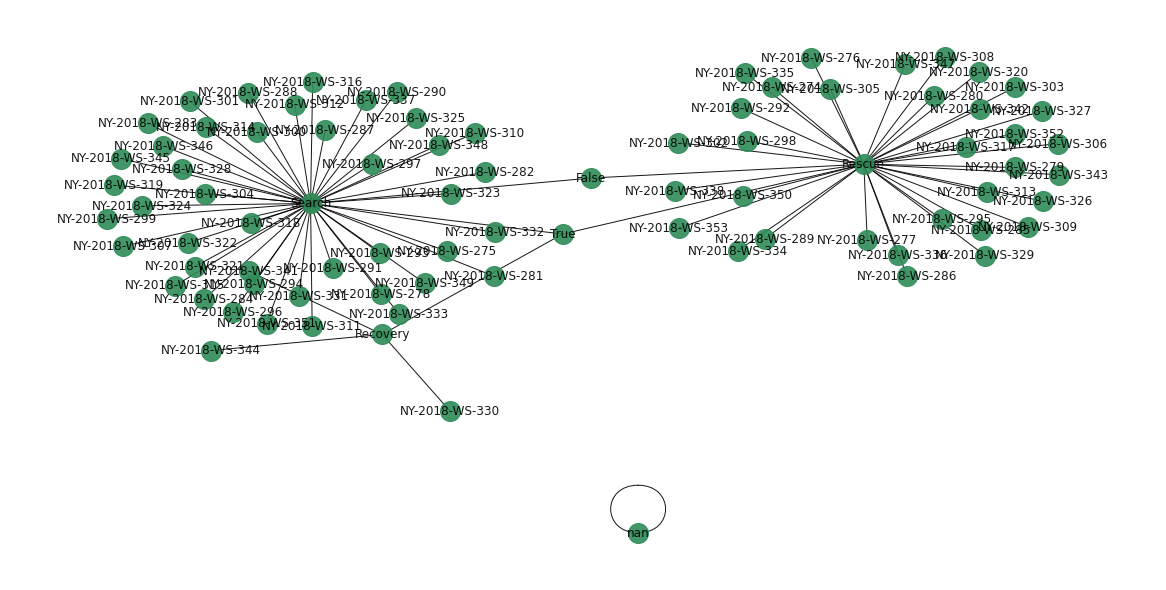

In [7]:
incident_num = incident_data.loc[:, "INCIDENT NUMBER"]
response = incident_data.loc[:, "RESPONSE TYPE"]
found = incident_data.loc[:, "FOUND IN SEARCH AREA"]

g = nx.Graph()

for i in range(incident_num.size):
    g.add_node(incident_num[i])
    g.add_node(response[i])
    g.add_node(found[i])
    g.add_edge(incident_num[i], response[i])
    g.add_edge(response[i], found[i])

pos = nx.spring_layout(g, k=0.5, iterations=80)
fig = plt.figure(figsize=(16,8))
nx.draw(g, pos, edge_color='black', width=1, linewidths=1,
        node_size=400, node_color='seagreen', alpha=0.9,
        labels={node: node for node in g.nodes()})
plt.axis('off')
plt.show()